In [1]:
from bs4 import BeautifulSoup as BS
import urllib as url
import pandas as pd
import numpy as np  
import re
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb


In [2]:
request = url.request.Request("https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
result = url.request.urlopen(request)
resulttext = result.read()

In [3]:
soup = BS(resulttext, 'html.parser')


In [4]:
# the html has a number of tables and we want to  have a table that we are looking for , so that we explictly 
#pass the characterstics of the tables  through class_ as an argument . We find the characterstics from the html 

earthquake_table_list = soup.find_all('table', class_=['sortable', 'wikitable', 'jquery-tablesorter'])

# we will assert if we have got the table that we want for , we wnat only one table

assert len(earthquake_table_list) == 1

#  since we have the list , we  want to convert the list in to table (have to check this again)

earthquake_table = earthquake_table_list[0]

In [5]:
# once we have the table, we want to extract the table header represented as 'th' by using the find_all, find_all 

table_head = earthquake_table.find_all('th')

# here we are assigning the table for  header by looping through table head . 
#The result of the .text() method is a string containing the combined text of all matched elements.

columns = [th.text for th in table_head]

In [6]:
print(columns)

['Origin (UTC)', 'Present-day country and link to Wikipedia article', 'Lat', 'Long', 'Depth (km)', 'Magnitude', 'Secondary Effects', 'PDE Shaking Deaths', 'PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']


In [7]:
# find_all the rows of the table and skip the first column as the table header is one child it self.

table_rows = earthquake_table.find_all('tr')[1:]

#do a loop , create an empty set for  and store it as df_rows

df_rows = list()
for row in table_rows:
    row_data= [data.text for data in row.find_all('td')]
    
    df_rows.append(row_data)

In [8]:
for row in df_rows[:5]:
    print(row)

['1900-05-11 17:23', 'Japan', '38.700', '141.100', '5', '7.0 MJMA', '', '', '', '', '', '']
['1900-07-12 06:25', 'Turkey', '40.300', '43.100', '', '5.9 Muk', '', '', '', '140', '', '']
['1900-10-29 09:11', 'Venezuela', '11.000', '-66.000', '0', '7.7 Mw', '', '', '', '', '', '']
['1901-02-15 00:00', 'China', '26.000', '100.100', '0', '6.5 Ms', '', '', '', '', '', '']
['1901-03-31 07:11', 'Bulgaria', '43.400', '28.700', '', '6.4 Muk', '', '', '', '4', '', '']


In [9]:
#   the next step is creating a data frame , where we combine the two tables  row and column tables.# the data and the header 
earthquake_df = pd.DataFrame(data=df_rows, columns=columns)
#earthquake_df.loc[earthquake_df['Present-day country and link to Wikipedia article']=='Iran']



In [10]:
#earthquake_df.replace(r'^\s*$', np.nan, inplace = True)

In [11]:
earthquake_df=earthquake_df.replace('', np.NaN)

In [12]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
Origin (UTC)                                         1340 non-null object
Present-day country and link to Wikipedia article    1340 non-null object
Lat                                                  1326 non-null object
Long                                                 1326 non-null object
Depth (km)                                           1250 non-null object
Magnitude                                            1339 non-null object
Secondary Effects                                    373 non-null object
PDE Shaking Deaths                                   739 non-null object
PDE Total Deaths                                     750 non-null object
Utsu Total Deaths                                    1027 non-null object
EM-DAT Total Deaths                                  560 non-null object
Other Source Deaths                                  37 non-null object
dtypes: obj

In [13]:
# renaming a columns, is  there any other mechanism to rename a target column alone
earthquake_df.columns=["Origin(UTC)","country","Lat","Long", "Depth(km)","Magnitude","Secondary Effects","PDE Shaking Deaths",
                       "PDE Total Deaths","Utsu Total Deaths","EM-DAT Total Deaths","Other Source Deaths"]

In [14]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
Origin(UTC)            1340 non-null object
country                1340 non-null object
Lat                    1326 non-null object
Long                   1326 non-null object
Depth(km)              1250 non-null object
Magnitude              1339 non-null object
Secondary Effects      373 non-null object
PDE Shaking Deaths     739 non-null object
PDE Total Deaths       750 non-null object
Utsu Total Deaths      1027 non-null object
EM-DAT Total Deaths    560 non-null object
Other Source Deaths    37 non-null object
dtypes: object(12)
memory usage: 125.7+ KB


In [15]:
# fixing issues with country columns  to have the unique name for each country.
# we need to make a decesion on the SaudiArabia/Egybt  observation

test="\s\(.*"
earthquake_df['country']= earthquake_df['country'].str.replace(test, "")
test2= "\,.*"
earthquake_df['country']=earthquake_df['country'].str.replace(test2, "")
test3="United States Minor.*"
earthquake_df['country']=earthquake_df['country'].str.replace(test3,"United States")
test4="US T.*"
earthquake_df['country']=earthquake_df['country'].str.replace(test4,"United States")
test5="\(.*"
earthquake_df['country']=earthquake_df['country'].str.replace(test5,"Venezuela")

In [16]:
#earthquake_df['country'].value_counts()
# here we are observing  that a country name followed by ',' [Iran, 2005 Qeshm earthquake ]                              1
#and  country names with parenthesis . 

In [17]:
#earthquake_df['Other Source Deaths'].value_counts()

In [18]:
#earthquake_df['Other Source Deaths']
earthquake_df[earthquake_df['Other Source Deaths'].str.contains('26000', na=False)]

,Origin(UTC),country,Lat,Long,Depth(km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
1206,2003-12-26 01:56,Iran,28.950,58.268,6,6.6 Mw,L,31000,31000,NaN,26796,26271[11] 26000[12]


In [19]:
# removing the footnotes and commas between numbers in [Other Source Deaths]
test6="\[\d+]|\+|\s\(.*|\*"
earthquake_df['Other Source Deaths']=earthquake_df['Other Source Deaths'].str.replace(test6,"")
test7="\,"
earthquake_df['Other Source Deaths']=earthquake_df['Other Source Deaths'].str.replace(test7,"")

In [20]:
#earthquake_df['Other Source Deaths'].value_counts()

In [21]:
d_types = set([type(val) for val in earthquake_df['Magnitude']])

In [22]:
d_types

{float, str}

In [23]:
# Converting magnitude to numeric 

earthquake_df['magnitude']=earthquake_df['Magnitude'].str.split(' ').str.get(0)
earthquake_df['magnitude']

d_types= set([type(val) for val in earthquake_df['magnitude']])
d_types

earthquake_df['magnitude'].dtype

earthquake_df.magnitude.values

earthquake_df.magnitude=earthquake_df.magnitude.astype(float).fillna(0.0)
earthquake_df.magnitude.values
earthquake_df['magnitude'].dtype

dtype('float64')

In [24]:
earthquake_df['Year']=earthquake_df['Origin(UTC)'].str.split('-').str.get(0)

In [25]:
earthquake_df['Year']=earthquake_df['Year'].astype(int)

In [26]:
earthquake_df.head()

,Origin(UTC),country,Lat,Long,Depth(km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,magnitude,Year
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1900
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140,NaN,NaN,5.9,1900
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN,7.7,1900
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1901
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4,NaN,NaN,6.4,1901


In [27]:
y=earthquake_df['Magnitude'].str.split(' ').str.get(1)
y.unique()

array(['MJMA', 'Muk', 'Mw', 'Ms', 'ML', 'mb', nan, 'Lg', 'Md', 'Mb'], dtype=object)

In [28]:
#Create a new column ('deaths')  FROM TOTAL DEATH COLUMNS AND POPULATES WITH THE HIGHEST VALUE


In [29]:
#Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).
earthquake_df['Other Source Deaths']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16        3500
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
         ...  
1310       NaN
1311       NaN
1312       NaN
1313       NaN
1314       NaN
1315       NaN
1316       NaN
1317        41
1318        60
1319       NaN
1320       215
1321        34
1322       295
1323       NaN
1324         1
1325        79
1326       189
1327      1115
1328    222517
1329       521
1330        42
1331         1
1332      2698
1333       181
1334       NaN
1335     15894
1336       150
1337       NaN
1338       111
1339       601
Name: Other Source Deaths, Length: 1340, dtype: object

In [30]:
x=earthquake_df.loc[earthquake_df['country']=='Iran']
x['Other Source Deaths'].value_counts()

8000           1
26271 26000    1
Name: Other Source Deaths, dtype: int64

In [31]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 14 columns):
Origin(UTC)            1340 non-null object
country                1340 non-null object
Lat                    1326 non-null object
Long                   1326 non-null object
Depth(km)              1250 non-null object
Magnitude              1339 non-null object
Secondary Effects      373 non-null object
PDE Shaking Deaths     739 non-null object
PDE Total Deaths       750 non-null object
Utsu Total Deaths      1027 non-null object
EM-DAT Total Deaths    560 non-null object
Other Source Deaths    37 non-null object
magnitude              1340 non-null float64
Year                   1340 non-null int32
dtypes: float64(1), int32(1), object(12)
memory usage: 141.4+ KB


In [32]:
#float(earthquake_df['PDE Total Deaths'])
  #  ', 'Utsu Total Deaths','EM-DAT Total Deaths', 'Other Source Deaths'])

In [33]:
type(earthquake_df['PDE Total Deaths'])

pandas.core.series.Series

In [34]:
d_types = set([type(val) for val in earthquake_df['Utsu Total Deaths']])
d_types

{float, str}

In [35]:
# earthquake_df.apply(pd.to_numeric, errors='ignore').info()
earthquake_df['PDE Total Deaths']=earthquake_df['PDE Total Deaths'].apply(pd.to_numeric, errors='coerce')
earthquake_df['Utsu Total Deaths']=earthquake_df['Utsu Total Deaths'].apply(pd.to_numeric, errors='coerce')
earthquake_df[ 'EM-DAT Total Deaths']=earthquake_df[ 'EM-DAT Total Deaths'].apply(pd.to_numeric, errors='coerce')
earthquake_df['Other Source Deaths']=earthquake_df['Other Source Deaths'].apply(pd.to_numeric, errors='coerce')  


In [36]:
earthquake_df['Total Deaths']=earthquake_df[['PDE Total Deaths', 'Utsu Total Deaths','EM-DAT Total Deaths', 'Other Source Deaths']].max(axis=1)

In [37]:
earthquake_df['Total Deaths'].head()

0      NaN
1    140.0
2      NaN
3      NaN
4      4.0
Name: Total Deaths, dtype: float64

In [38]:
#earthquake_df.head()

In [39]:
frequency=earthquake_df['country'].value_counts()

In [40]:
frequency.head()

China        166
Indonesia     96
Turkey        95
Iran          92
Japan         82
Name: country, dtype: int64

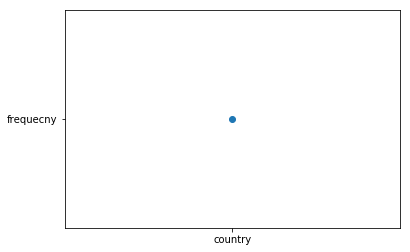

In [41]:
plt.scatter('country', 'frequecny')

In [42]:
earthquake_df['frequecny_eq']=frequency

In [43]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 16 columns):
Origin(UTC)            1340 non-null object
country                1340 non-null object
Lat                    1326 non-null object
Long                   1326 non-null object
Depth(km)              1250 non-null object
Magnitude              1339 non-null object
Secondary Effects      373 non-null object
PDE Shaking Deaths     739 non-null object
PDE Total Deaths       750 non-null float64
Utsu Total Deaths      1027 non-null float64
EM-DAT Total Deaths    559 non-null float64
Other Source Deaths    35 non-null float64
magnitude              1340 non-null float64
Year                   1340 non-null int32
Total Deaths           1273 non-null float64
frequecny_eq           0 non-null float64
dtypes: float64(7), int32(1), object(8)
memory usage: 162.3+ KB


In [44]:
#earthquake_df.set_index(['Origin(UTC)'])

In [45]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 16 columns):
Origin(UTC)            1340 non-null object
country                1340 non-null object
Lat                    1326 non-null object
Long                   1326 non-null object
Depth(km)              1250 non-null object
Magnitude              1339 non-null object
Secondary Effects      373 non-null object
PDE Shaking Deaths     739 non-null object
PDE Total Deaths       750 non-null float64
Utsu Total Deaths      1027 non-null float64
EM-DAT Total Deaths    559 non-null float64
Other Source Deaths    35 non-null float64
magnitude              1340 non-null float64
Year                   1340 non-null int32
Total Deaths           1273 non-null float64
frequecny_eq           0 non-null float64
dtypes: float64(7), int32(1), object(8)
memory usage: 162.3+ KB


In [46]:
#earthquake_df['Origin(UTC)']

In [47]:
percapita=pd.read_csv("UN_GDP.csv")

In [48]:
percapita.head()

,Country or Area,Year,Item,Value
0,Afghanistan,2015,Gross Domestic Product (GDP),623.184798
1,Afghanistan,2014,Gross Domestic Product (GDP),667.883420
2,Afghanistan,2013,Gross Domestic Product (GDP),704.322178
3,Afghanistan,2012,Gross Domestic Product (GDP),717.563696
4,Afghanistan,2011,Gross Domestic Product (GDP),665.429433


In [49]:
percapita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9234 entries, 0 to 9233
Data columns (total 4 columns):
Country or Area    9234 non-null object
Year               9234 non-null int64
Item               9234 non-null object
Value              9234 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 288.6+ KB


In [50]:
percapita.drop(['Item'], axis=1, inplace=True)

In [51]:
percapita.columns=['country','Year','Percapiata_GDP USD']

In [52]:
percapita.head()

,country,Year,Percapiata_GDP USD
0,Afghanistan,2015,623.184798
1,Afghanistan,2014,667.883420
2,Afghanistan,2013,704.322178
3,Afghanistan,2012,717.563696
4,Afghanistan,2011,665.429433


In [53]:
percapita.tail()

,country,Year,Percapiata_GDP USD
9229,Zimbabwe,1974,716.246743
9230,Zimbabwe,1973,615.817137
9231,Zimbabwe,1972,518.197928
9232,Zimbabwe,1971,434.259540
9233,Zimbabwe,1970,388.472837


In [54]:
#percapita.set_index(['country', 'Year'],inplace=True)

In [55]:
percapita.head()

,country,Year,Percapiata_GDP USD
0,Afghanistan,2015,623.184798
1,Afghanistan,2014,667.883420
2,Afghanistan,2013,704.322178
3,Afghanistan,2012,717.563696
4,Afghanistan,2011,665.429433


In [56]:
pop=pd.read_csv("UNdata_Pop_1970_2015.csv")

In [57]:
pop.head()

,Country or Area,Year(s),Variant,Value
0,Afghanistan,2015,Medium,33736.494
1,Afghanistan,2015,High,33736.494
2,Afghanistan,2015,Low,33736.494
3,Afghanistan,2015,Constant fertility,33736.494
4,Afghanistan,2015,Instant replacement,33736.494


In [58]:
pop.tail()

,Country or Area,Year(s),Variant,Value
99995,Timor-Leste,1991,Zero migration,777.011
99996,Timor-Leste,1991,Constant mortality,777.011
99997,Timor-Leste,1991,No change,777.011
99998,Timor-Leste,1991,Momentum,777.011
99999,Timor-Leste,1990,Medium,751.933


In [59]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
Country or Area    100000 non-null object
Year(s)            100000 non-null int64
Variant            100000 non-null object
Value              100000 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [60]:
pop['Year(s)']=pop['Year(s)'].astype(int)
pop['Value']=pop['Value'].astype(int)

In [61]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
Country or Area    100000 non-null object
Year(s)            100000 non-null int32
Variant            100000 non-null object
Value              100000 non-null int32
dtypes: int32(2), object(2)
memory usage: 2.3+ MB


In [62]:
pop.drop(['Variant'], axis=1, inplace=True)

In [63]:
pop.columns=["Country","Year", "Value in '000"]

In [64]:
pop.set_index(['Country','Year'], inplace=True)

In [65]:
pop.head()

Value in '000
Country     Year               
Afghanistan 2015          33736
            2015          33736
            2015          33736
            2015          33736
            2015          33736

In [66]:
pop.tail()

Value in '000
Country     Year               
Timor-Leste 1991            777
            1991            777
            1991            777
            1991            777
            1990            751

In [67]:
earthquakes=pd.merge(earthquake_df, percapita ,how='inner',on=('country','Year'))

In [68]:
earthquakes.sort_values('country')

,Origin(UTC),country,Lat,Long,Depth(km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,magnitude,Year,Total Deaths,frequecny_eq,Percapiata_GDP USD
560,2005-12-12 21:47,Afghanistan,36.285,71.120,223.8,6.5 Mw,NaN,5,5.0,NaN,5.0,NaN,6.5,2005,5.0,NaN,271.387211
484,2002-03-27 08:52,Afghanistan,36.053,69.248,9.1,5.6 Mw,L,NaN,NaN,NaN,NaN,NaN,5.6,2002,NaN,NaN,199.430096
401,1998-02-20 12:18,Afghanistan,36.479,71.074,236,6.3 Mw,L,1,1.0,1.0,1.0,NaN,6.3,1998,1.0,NaN,157.305632
485,2002-04-12 04:00,Afghanistan,35.988,69.296,7.8,5.8 Mw,L,50,50.0,50.0,50.0,NaN,5.8,2002,50.0,NaN,199.430096
402,1998-05-30 06:22,Afghanistan,37.185,70.075,35.5,6.5 Mw,L,4000,4000.0,4000.0,4700.0,NaN,6.5,1998,4700.0,NaN,157.305632
403,1998-12-11 20:16,Afghanistan,36.518,71.000,219,5.6 Mw,NaN,5,5.0,5.0,NaN,NaN,5.6,1998,5.0,NaN,157.305632
483,2002-03-25 14:56,Afghanistan,36.051,69.210,10.5,6.1 Mw,L,1000,1000.0,1000.0,1000.0,NaN,6.1,2002,1000.0,NaN,199.430096
416,1999-02-11 14:08,Afghanistan,34.323,69.165,25.5,6.0 Mw,NaN,70,70.0,70.0,70.0,NaN,6.0,1999,70.0,NaN,142.868588
53,1976-03-19 13:03,Afghanistan,36.587,67.758,18.2,5.6 mb,L,49,49.0,49.0,50.0,NaN,5.6,1976,50.0,NaN,199.164810
90,1978-03-16 02:00,Afghanistan,29.928,66.234,10.2,6.1 Mw,NaN,1,1.0,NaN,NaN,NaN,6.1,1978,1.0,NaN,249.573709


In [69]:
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 0 to 619
Data columns (total 17 columns):
Origin(UTC)            620 non-null object
country                620 non-null object
Lat                    612 non-null object
Long                   612 non-null object
Depth(km)              613 non-null object
Magnitude              620 non-null object
Secondary Effects      216 non-null object
PDE Shaking Deaths     548 non-null object
PDE Total Deaths       556 non-null float64
Utsu Total Deaths      417 non-null float64
EM-DAT Total Deaths    320 non-null float64
Other Source Deaths    19 non-null float64
magnitude              620 non-null float64
Year                   620 non-null int32
Total Deaths           601 non-null float64
frequecny_eq           0 non-null float64
Percapiata_GDP USD     620 non-null float64
dtypes: float64(8), int32(1), object(8)
memory usage: 84.8+ KB


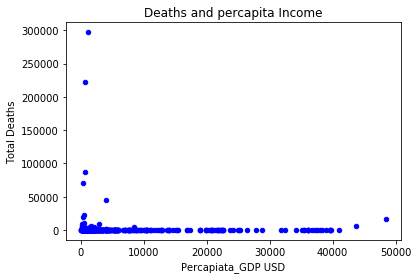

In [70]:
earthquakes.plot.scatter('Percapiata_GDP USD', 'Total Deaths', c='blue')
plt.title('Deaths and percapita Income')
plt.show()

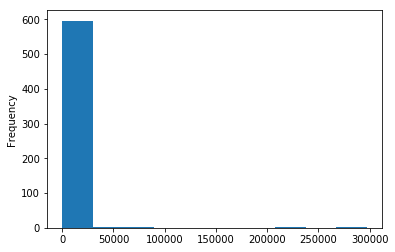

In [71]:
earthquakes['Total Deaths'].plot.hist()

In [72]:
# number of earthquake frequency has happend since 1900 per country 
# total deaths by country 

# generating an earthquake frequncy by country , total damage by country, and bubled graph.. death versus earthquake frequency 
# percapita versus earthquake total damage


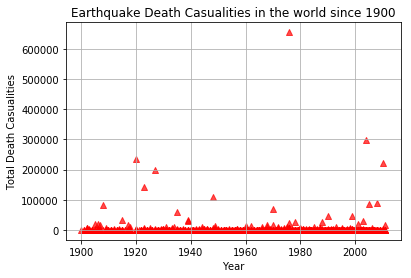

In [73]:
#plt.scatter(earthquake_df['country'].value_counts(), earthquake_df['country'], marker='o',  color='green', alpha=0.7)
plt.scatter( earthquake_df['Year'],earthquake_df['Total Deaths'],marker='^',color='red', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Total Death Casualities' )
plt.title('Earthquake Death Casualities in the world since 1900')
plt.grid('TRUE')


plt.show()

In [74]:
earthquake_df['Total Deaths'].nlargest(5)

583     655237.0
1238    297200.0
102     235502.0
1328    222517.0
140     200000.0
Name: Total Deaths, dtype: float64

In [75]:
earthquake_df['country'].count()

1340

In [76]:
earthquake_df['Total Deaths'].max()

655237.0

In [77]:
earthquake_df['Total Deaths'].min()

0.0

In [78]:
#df['cn'][df['cn]=='row name'].sum

In [100]:
#earthquake_df['country'][earthquake_df['Total Deaths']=='China'].dum()

In [106]:
earthquake_df['Secondary Effects'].nunique()

12

In [81]:
print(earthquake_df.groupby('country').groups.keys())

dict_keys(['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burma', 'Burundi', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'Eritrea', 'Ethiopia', 'Fiji', 'France', 'Georgia', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Judea and Samaria', 'Kazakhstan', 'Kingdom of Yugoslavia', 'Kyrgyzstan', 'Macedonia', 'Malawi', 'Malaysia', 'Mandatory Palestine and Transjordan', 'Martinique', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Pakistan', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Ric

In [82]:
len(earthquake_df.groupby(['country']).groups['China'])

166

In [83]:
occurrence_freq=earthquake_df['country'].value_counts()

In [84]:
occurrence_freq.head()

China        166
Indonesia     96
Turkey        95
Iran          92
Japan         82
Name: country, dtype: int64

In [85]:
#occurrence_freq=occurrence_freq.to_frame()

In [86]:
#occurrence_freq.columns=['frequency']

In [87]:
#occurrence_freq.head()

In [88]:
occurrence_freq.head()

China        166
Indonesia     96
Turkey        95
Iran          92
Japan         82
Name: country, dtype: int64

In [89]:
#earthquake_df.groupby('country').first()

In [90]:
total_death=earthquake_df.groupby(['country'], as_index=False)['Total Deaths'].sum()
#total_death.columns=total_death.columns.droplevel(level=0)

In [91]:
total_death.head()

,country,Total Deaths
0,Afghanistan,10199.0
1,Albania,244.0
2,Algeria,9366.0
3,Argentina,10584.0
4,Armenia,25390.0


In [92]:
type(total_death)

pandas.core.frame.DataFrame

In [93]:
total_death['frequency']=''

In [94]:
total_death.head()

,country,Total Deaths,frequency
0,Afghanistan,10199.0,
1,Albania,244.0,
2,Algeria,9366.0,
3,Argentina,10584.0,
4,Armenia,25390.0,


In [95]:
#plt.scatter(occurrence_freq,total_death,alpha=0.7)
#plt.grid('TRUE')

In [128]:
occurrence_death=earthquake_df[['country', 'Total Deaths']].groupby(['country']).agg(['sum','count'])
occurrence_death.head()

Total Deaths      
                     sum count
country                       
Afghanistan      10199.0    29
Albania            244.0     7
Algeria           9366.0    19
Argentina        10584.0    11
Armenia          25390.0     2

In [132]:
occurrence_death.columns=['Total Deaths', 'Frequency of Eq']

In [133]:
occurrence_death.head()

,Total Deaths,Frequency of Eq
country,,
Afghanistan,10199.0,29
Albania,244.0,7
Algeria,9366.0,19
Argentina,10584.0,11
Armenia,25390.0,2


In [136]:
occurrence_death.sort_values(['Frequency of Eq'], ascending=False)

,Total Deaths,Frequency of Eq
country,,
China,1284382.0,151
Turkey,123304.0,93
Iran,177960.0,92
Indonesia,343574.0,92
Japan,185148.0,78
Peru,74054.0,53
Taiwan,8165.0,48
Mexico,14373.0,44
Chile,58602.0,42


In [125]:
type(occurrence_death)

pandas.core.frame.DataFrame

In [121]:
earthquake_df

,Origin(UTC),country,Lat,Long,Depth(km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,magnitude,Year,Total Deaths,frequecny_eq
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1900,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140.0,NaN,NaN,5.9,1900,140.0,NaN
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN,7.7,1900,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1901,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4.0,NaN,NaN,6.4,1901,4.0,NaN
5,1901-08-09 09:23,Japan,40.500,142.500,35,7.2 Mw,T,NaN,NaN,NaN,NaN,NaN,7.2,1901,NaN,NaN
6,1901-11-15 20:15,New Zealand,-43.000,173.000,0,6.8 Ms,NaN,NaN,NaN,1.0,NaN,NaN,6.8,1901,1.0,NaN
7,1902-01-30 14:01,Japan,40.500,141.300,35,6.9 Ms,NaN,NaN,NaN,1.0,NaN,NaN,6.9,1902,1.0,NaN
8,1902-02-13 09:39,Azerbaijan,40.700,48.600,15,6.9 Muk,NaN,NaN,NaN,86.0,NaN,NaN,6.9,1902,86.0,NaN
9,1902-03-09 07:46,Turkey,40.700,33.600,NaN,5.5 Muk,NaN,NaN,NaN,4.0,NaN,NaN,5.5,1902,4.0,NaN


In [120]:
earthquake_df[['country','Total Deaths']].groupby(['country']).agg(['count'])

,Total Deaths
,count
country,
Afghanistan,29
Albania,7
Algeria,19
Argentina,11
Armenia,2
Australia,3
Azerbaijan,4
Bangladesh,5
